# <center> LSTM и 1D CNN
# <center> Summary

In [1]:
import os
os.chdir("..")

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import time

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## data

In [5]:
data_path = "data"

In [6]:
X_train = np.load(os.path.join(data_path, "X_train.npy"))
X_test = np.load(os.path.join(data_path, "X_test.npy"))
y_train = np.load(os.path.join(data_path, "y_train.npy"))
y_test = np.load(os.path.join(data_path, "y_test.npy"))

In [7]:
X_train.shape, y_train.shape

((7352, 128, 9), (7352, 6))

In [8]:
X_test.shape, y_test.shape

((2947, 128, 9), (2947, 6))

#### посмотрим на баланс классов

In [10]:
pd.Series(y_train.argmax(1)).value_counts().sort_index()

0    1226
1    1073
2     986
3    1286
4    1374
5    1407
dtype: int64

В первом приближении классы можно считать близкими к сбалансированным

#### нормализуем данные и переведем их в torch

In [11]:
X_train_mean = X_train.mean(0)
X_train_std = X_train.std(0)

In [12]:
X_train_norm = (X_train - X_train_mean) / X_train_std
X_test_norm = (X_test - X_train_mean) / X_train_std

In [13]:
X_train_norm = torch.FloatTensor(X_train_norm)
X_test_norm = torch.FloatTensor(X_test_norm)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

#### организуем данные для обучения

In [15]:
class DatasetCustom(Dataset):
    """
    Кастомный класс датасета
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, key):
        return self.x[key], self.y[key]

In [17]:
BATCH_SIZE = 64

train_dataset = DatasetCustom(X_train_norm, y_train)
test_dataset = DatasetCustom(X_test_norm, y_test)

dataloader_train = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True
                              )

dataloader_test = DataLoader(test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            drop_last=True
                            )
len(dataloader_train), len(dataloader_test)

(114, 46)

#### готовим обучение

In [26]:
def train_model(model, dataloaders, optimizer, num_epochs=3):
    since = time.time()

    history = {'train': defaultdict(lambda : []), 'val': defaultdict(lambda : [])}

    for epoch in range(num_epochs):
        print(f'    Epoch {epoch + 1}/{num_epochs}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_loss = 0.0

            # Iterate over data.
            n_batches = len(dataloaders[phase])
            for inputs, y in dataloaders[phase]:
                inputs = inputs.to(device)
                y = y.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = model.loss(outputs, y)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # loss accumulate
                epoch_loss += loss.item()
                
            # statistics
            epoch_loss = epoch_loss / len(dataloaders[phase])
            
            X = X_train_norm if phase == "train" else X_test_norm
            y_ = y_train if phase == "train" else y_test
            pred_probs = model(X.to(device))
            pred_labels = torch.argmax(pred_probs, dim=1)
            true_labels = torch.argmax(y_, dim=1)
            
            precision = precision_score(true_labels, pred_labels.cpu(), average='micro')
            recall = recall_score(true_labels, pred_labels.cpu(), average='micro')
            roc_auc = roc_auc_score(y_, pred_probs.cpu().detach().numpy(), multi_class="ovo")
            
            history[phase]["Loss"].append(epoch_loss)
            history[phase]["precision"].append(precision)
            history[phase]["recall"].append(recall)
            history[phase]["roc_auc"].append(roc_auc)
            
            print(f'{phase} Loss: {epoch_loss:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, roc_auc: {roc_auc:.4f}, ')
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return model, history

#### готовим вывод графиков результата обучения

In [ ]:
def history_plot(history, plot_items: list, title=None):
    plt.figure(figsize=(10, 6))

    for mode in history:
        for item in plot_items:
            plt.plot(history[mode][item], label=f"{mode} {item}")
    if not title:
        title = ", ".join(plot_items)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.legend()
    plt.grid()

## <center>модель 1: LSTM

In [51]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, dropout=0.2, batch_first=True):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.batch_first = batch_first
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, dropout=dropout, batch_first=True)  # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128)  # fully connected 1
        self.fc = nn.Linear(128, num_classes)  # fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self, input):
        _, (hn, _) = self.lstm(input)
        out = self.relu(hn[-1])
        out = self.fc_1(out)  # first Dense
        out = self.relu(out)  # relu
        out = self.fc(out)  # Final Output
        return out
    
    def loss(self, y_pred, y_true):
        loss = nn.CrossEntropyLoss()
        return loss(y_pred, y_true)

### settings

In [52]:
input_size = X_train_norm.shape[2]
num_classes = y_train.shape[1]
input_size, num_classes

(9, 6)

In [56]:
model1 = LSTM(input_size=input_size, hidden_size=100, num_classes=num_classes, num_layers=2).to(device)

optimizer = torch.optim.Adam(model1.parameters())
dataloaders = {
    "train": dataloader_train, 
    "val": dataloader_test
}

### train

In [57]:
model1, history1 = train_model(model1, dataloaders, optimizer, num_epochs=30)

    Epoch 1/30
train Loss: 1.2221, precision: 0.4086, recall: 0.4086, roc_auc: 0.8627, 
val Loss: 1.0219, precision: 0.4174, recall: 0.4174, roc_auc: 0.8523, 
    Epoch 2/30
train Loss: 0.8086, precision: 0.6715, recall: 0.6715, roc_auc: 0.9014, 
val Loss: 0.8275, precision: 0.6166, recall: 0.6166, roc_auc: 0.8800, 
    Epoch 3/30
train Loss: 0.5780, precision: 0.8591, recall: 0.8591, roc_auc: 0.9772, 
val Loss: 0.5778, precision: 0.8273, recall: 0.8273, roc_auc: 0.9661, 
    Epoch 4/30
train Loss: 0.3653, precision: 0.9325, recall: 0.9325, roc_auc: 0.9922, 
val Loss: 0.4487, precision: 0.8673, recall: 0.8673, roc_auc: 0.9759, 
    Epoch 5/30
train Loss: 0.1714, precision: 0.9252, recall: 0.9252, roc_auc: 0.9919, 
val Loss: 0.5506, precision: 0.8381, recall: 0.8381, roc_auc: 0.9745, 
    Epoch 6/30
train Loss: 0.1510, precision: 0.9563, recall: 0.9563, roc_auc: 0.9947, 
val Loss: 0.2997, precision: 0.9026, recall: 0.9026, roc_auc: 0.9873, 
    Epoch 7/30
train Loss: 0.1423, precision: 

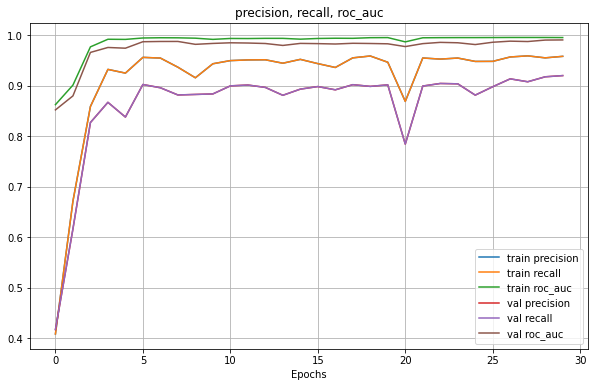

In [58]:
history_plot(history1, ["precision", "recall", "roc_auc"])

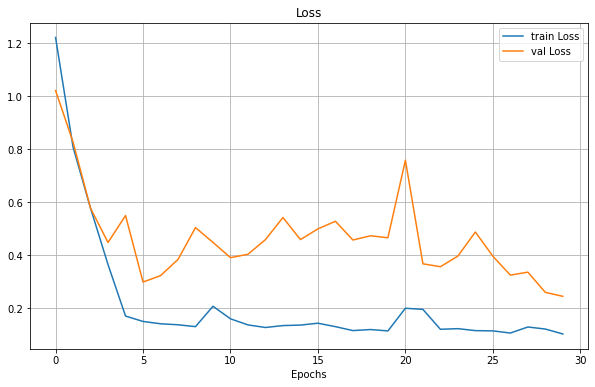

In [59]:
history_plot(history1, ["Loss"])

### Посмотрим, какие метрики получаются на тестовой выборке

In [61]:
pred_probs = model1(X_test_norm.to(device))
pred_labels = torch.argmax(pred_probs, dim=1)
true_labels = torch.argmax(y_test, dim=1)

precision = precision_score(true_labels, pred_labels.cpu(), average='micro')
recall = recall_score(true_labels, pred_labels.cpu(), average='micro')
roc_auc = roc_auc_score(y_test, pred_probs.cpu().detach().numpy(), multi_class="ovo")

print(f"precision = {round(precision, 3)}")
print(f"recall = {round(recall, 3)}")
print(f"roc_auc = {round(roc_auc, 3)}")

precision = 0.92
recall = 0.92
roc_auc = 0.991


## <center>модель 2: CNN 1D

In [152]:
class CNN1D(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout=0.2):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.dropout = dropout

        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=hidden_size, 
                               kernel_size=3, padding="same"), 
            nn.ReLU(), 
            nn.MaxPool1d(2, stride=2), 
            nn.Dropout(p=dropout)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, 
                               kernel_size=3, padding="same"), 
            nn.ReLU(), 
            nn.MaxPool1d(2, stride=2), 
            nn.Dropout(p=dropout)
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, 
                               kernel_size=3, padding="same"), 
            nn.ReLU(), 
            nn.MaxPool1d(2, stride=2), 
            nn.Dropout(p=dropout)
        )
        self.fc1 =  nn.Linear(16 * hidden_size, 128)  # fully connected 1
        self.drop = nn.Dropout()
        self.fc = nn.Linear(128, num_classes)  # fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self, input):
        input = input.transpose(2, 1)
        x = self.layer1(input)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)  # first Dense
        x = self.relu(x)
        x = self.drop(x)
        out = self.fc(x)  # Final Output
        return out
    
    def loss(self, y_pred, y_true):
        loss = nn.CrossEntropyLoss()
        return loss(y_pred, y_true)

### settings

In [153]:
input_size = X_train_norm.shape[2]
num_classes = y_train.shape[1]
input_size, num_classes

(9, 6)

In [157]:
model2 = CNN1D(input_size=input_size, hidden_size=10, num_classes=num_classes, dropout=0.1).to(device)

optimizer = torch.optim.Adam(model2.parameters())
dataloaders = {
    "train": dataloader_train, 
    "val": dataloader_test
}

### train

In [158]:
model2, history2 = train_model(model2, dataloaders, optimizer, num_epochs=40)

    Epoch 1/40
train Loss: 1.0269, precision: 0.7926, recall: 0.7926, roc_auc: 0.9112, 
val Loss: 0.6036, precision: 0.7655, recall: 0.7655, roc_auc: 0.9060, 
    Epoch 2/40
train Loss: 0.3887, precision: 0.8818, recall: 0.8818, roc_auc: 0.9394, 
val Loss: 0.4805, precision: 0.8334, recall: 0.8334, roc_auc: 0.9375, 
    Epoch 3/40
train Loss: 0.2702, precision: 0.9048, recall: 0.9048, roc_auc: 0.9461, 
val Loss: 0.4396, precision: 0.8717, recall: 0.8717, roc_auc: 0.9460, 
    Epoch 4/40
train Loss: 0.2291, precision: 0.9226, recall: 0.9226, roc_auc: 0.9598, 
val Loss: 0.3976, precision: 0.8884, recall: 0.8884, roc_auc: 0.9672, 
    Epoch 5/40
train Loss: 0.2033, precision: 0.9202, recall: 0.9202, roc_auc: 0.9637, 
val Loss: 0.3512, precision: 0.8924, recall: 0.8924, roc_auc: 0.9761, 
    Epoch 6/40
train Loss: 0.1829, precision: 0.9301, recall: 0.9301, roc_auc: 0.9639, 
val Loss: 0.3334, precision: 0.8985, recall: 0.8985, roc_auc: 0.9729, 
    Epoch 7/40
train Loss: 0.1684, precision: 

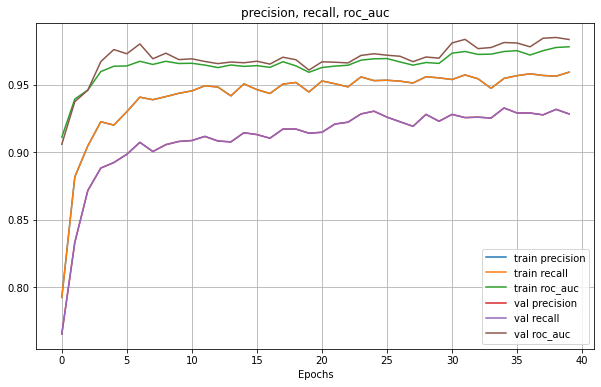

In [160]:
history_plot(history2, ["precision", "recall", "roc_auc"])

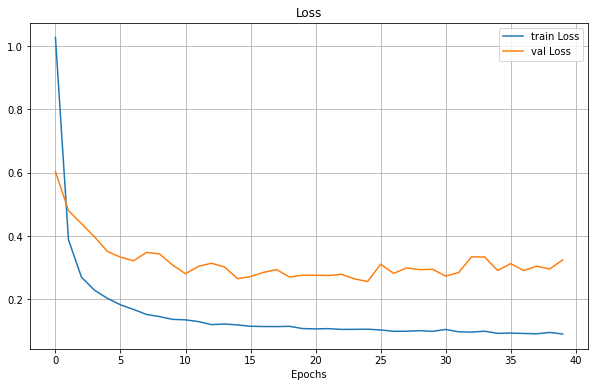

In [161]:
history_plot(history2, ["Loss"])

### Посмотрим, какие метрики получаются на тестовой выборке

In [162]:
pred_probs = model2(X_test_norm.to(device))
pred_labels = torch.argmax(pred_probs, dim=1)
true_labels = torch.argmax(y_test, dim=1)

precision = precision_score(true_labels, pred_labels.cpu(), average='micro')
recall = recall_score(true_labels, pred_labels.cpu(), average='micro')
roc_auc = roc_auc_score(y_test, pred_probs.cpu().detach().numpy(), multi_class="ovo")

print(f"precision = {round(precision, 3)}")
print(f"recall = {round(recall, 3)}")
print(f"roc_auc = {round(roc_auc, 3)}")

precision = 0.928
recall = 0.928
roc_auc = 0.983


# <center>Summary

1) Было создано и обучено **3 модели**:
    - ML модель на базе градиентного бустинга (XGBoost) с деревьями в качестве базового алгоритма и с предварительным **Feature Engineering**
    - DL модель на базе рекурентной архитектуры LSTM с базовой предобработкой фичей
    - DL модель на базе архитектуры 1D CNN с базовой предобработкой фичей

2) Во всех 3-х моделях базовый порог **0.92** преодолен, но наилучшие результаты у модели 1D CNN,  немного отстал XGBoost, замыкает LSTM

3) ML модели требуют больше усилий по Feature Engineering и предобработке фичей, но усилия по созданию самой модели сравнительно невелики. DL модели, наоборот, требуют сравнительно небольшую предобработку фичей, но больше усилий по созданию самих моделей и кода для обучения и контроля обучения. 

4) Если сравнивать DL модели, то 1D CNN модель обучается быстрее и показыват более высокие результаты, чем LSTM

5) Для дальнейшего улучшения результатов:
    - для ML моделей 
        - работа по линии Feature Engineering
        - ансамблирование разных моделей
        - более тонкая настройка моделей
    - для DL моделей
        - оптимизация архитектуры
        - более тонкая настройка

6) Исходя из проведенного исследования для этой задачи использование DL модели архитектуры 1D CNN выглядит более предпочтительно